In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
batch_size = 64

root = './MNIST_Fashion'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = torchvision.datasets.FashionMNIST(root=root, train=True, transform=transform, download = True)
test_data = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transform, download = True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False, drop_last = True)


Extracting ./MNIST_Fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw




Extracting ./MNIST_Fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw




Extracting ./MNIST_Fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw




Extracting ./MNIST_Fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Fashion_MNIST/fashion-mnist_train.csv')
train_df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.shape

(60000, 785)

In [5]:
train, val = train_test_split(train_df, test_size=0.1, 
                              shuffle=True, random_state=9)
#test_size=0.1 gives a good result

In [6]:
print(train.shape, val.shape)

(54000, 785) (6000, 785)


In [7]:
train.drop(columns=['label']).mean().mean()

72.93507596371884

In [8]:
aug1_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transforms.RandomRotation(25),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528)) 
])

aug2_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomVerticalFlip(p=0.6),
                           transforms.RandomRotation(40),
                           transforms.RandomHorizontalFlip(p=1),
                           transforms.RandomAffine(degrees=30, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528)) 
])

aug3_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomRotation(degrees=(-90, 90)),
                           transforms.RandomVerticalFlip(p=0.6),
                           transforms.RandomRotation(40),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528)) 
])

train_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528))    
])

val_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((0.2861), (0.3528))
])

In [ ]:
class MyDataSet(Dataset):
  def __init__(self, features, labels, Transform):
    self.x = features
    self.y = labels
    self.transform = Transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.transform(self.x[index]), self.y[index]

In [ ]:
def GetDf(df, Transform):
  x_train = df.iloc[:, 1:].values
  y_train = df.label.values
  x_train = x_train.reshape(-1, 1, 28, 28)
  x_train = np.uint8(x_train)
  y_train = torch.from_numpy(y_train).type(torch.LongTensor)
  x_train = torch.from_numpy(x_train)
  return MyDataSet(x_train, y_train, Transform)

In [ ]:
datasets = {
    'aug1':  GetDf(train_df, aug1_transformers),
    'aug2':  GetDf(train_df, aug2_transformers),
    'aug3':  GetDf(train_df, aug3_transformers),
    'train': GetDf(train, train_transformers),
    'val': GetDf(val, val_transformers)
}

# new_train = ConcatDataset([datasets['train'], datasets['aug1'], datasets['aug2'],datasets['aug3']])
new_train = ConcatDataset([datasets['train'], datasets['aug1']])
loaders = {
    'train': DataLoader(new_train, batch_size=64, shuffle = True, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=64, shuffle = True, num_workers=4)
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#for metrics
dataset_sizes = { 'train': len(new_train), 'val': len(datasets['val'])}

#for normalization
dataset_sizes_for_norm = {'train': len(datasets['train']), 'val': len(datasets['val'])}
loaders_for_norm = {
    'train': DataLoader(datasets['train'], batch_size=64, shuffle = True, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=64, shuffle = True, num_workers=4)
}

#show
dataset_sizes, dataset_sizes_for_norm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


({'train': 114000, 'val': 6000}, {'train': 54000, 'val': 6000})

In [ ]:
for x in ['train', 'val']:
   
  #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
  num_pxl = dataset_sizes_for_norm[x]*28*28
    
  #we go through the butches and sum up the pixels of the objects, 
  #which then divide the sum by the number of all pixels to calculate the average
  total_sum = 0
  for batch in loaders_for_norm[x]: 
    total_sum += batch[0].sum()
  mean = total_sum / num_pxl

    #we calculate the standard deviation using the formula that I indicated above
  sum_sqrt = 0
  for batch in loaders_for_norm[x]: sum_sqrt += ((batch[0] - mean).pow(2)).sum()
  std = torch.sqrt(sum_sqrt / num_pxl)

#   print(f'{x} - mean: {mean}, std: {std}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(<matplotlib.image.AxesImage at 0x7f80e6615990>,
 tensor(-0.1845),
 tensor(0.9054))

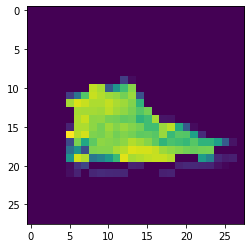

In [ ]:
i = np.random.randint(50)
x, y = next(iter(loaders['train']))
plt.imshow(x[i].view(28,28),), x.mean(), x.std()

In [ ]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(nn.Linear(256, num_classes))

      if init_weights:
        self.initialize_weights()
  
  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 

cfgs: Dict[str, List[Union[int, str]]] = {
    'A':[64, 'M', 128, 128, 'M', 256, 256, 256],
    'B':[16, 'M', 256, 'M'],
    'firstPadding':2
}
# cfgs: Dict[str, List[Union[str, int]]] = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }



def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Moduel] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 10)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [ ]:
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/10
train - loss:0.5035945116678874, accuracy0.8154298245614034
val - loss:0.36400371106465657, accuracy0.8671666666666666
Time: 0.0m 58.81338715553284s
Epoch: 2/10
train - loss:0.3426502328943788, accuracy0.8736052631578947
val - loss:0.25580975782871246, accuracy0.9043333333333333
Time: 1.0m 57.91310214996338s
Epoch: 3/10
train - loss:0.29813645495343627, accuracy0.8899122807017543
val - loss:0.22105786325534185, accuracy0.9185
Time: 2.0m 57.101969718933105s
Epoch: 4/10
train - loss:0.2724344777977257, accuracy0.8991315789473684
val - loss:0.2094405558904012, accuracy0.9258333333333333
Time: 3.0m 56.578169107437134s
Epoch: 5/10
train - loss:0.21498014669460164, accuracy0.9213508771929824
val - loss:0.17433546052376428, accuracy0.9353333333333333
Time: 4.0m 55.59351825714111s
Epoch: 6/10
train - loss:0.20077724595237195, accuracy0.9257017543859648
val - loss:0.16732714335123697, accuracy0.9391666666666666
Time: 5.0m 54.964834451675415s
Epoch: 7/10
train - loss:0.19173062002240

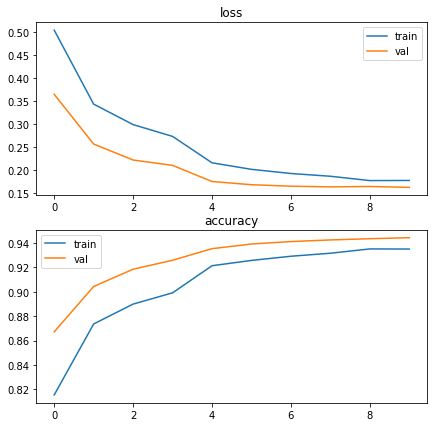

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], accuracies['train'], label ='train')
axs[1].plot([x for x in range(epochs)], accuracies['val'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Fashion_MNIST/fashion-mnist_test.csv')
test_df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_test_transformers = transforms.Compose([
                         transforms.ToPILImage(),
                         transforms.ToTensor(),
                         transforms.Normalize((0.2869), (0.3540)) 
                         #transforms.Normalize((0.5), (0.5))     
])

In [ ]:
datasetsq = GetDf(test_df, test_test_transformers)

loadersq=  DataLoader(datasetsq, batch_size=32, shuffle = True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizesq = len(datasetsq)
dataset_sizesq

10000

In [ ]:
num_px = dataset_sizesq*28*28


total_sum = 0
for batch in loadersq: total_sum += batch[0].sum()
mean = total_sum / num_px

sum_of_squared_error = 0
for batch in loadersq: sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_px)

mean, std

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(tensor(1.4451e-05), tensor(1.0000))

In [ ]:
corr = 0
 
with torch.no_grad(): 
    for data in loadersq:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images) 
        _, predicted = torch.max(y_pred, 1) 
        corr += torch.sum(predicted == labels.data)
 
print(f"Test accuracy: {corr/dataset_sizesq}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test accuracy: 0.9438999891281128
